[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - Surrogate Gradient Descent in a Convolutional Spiking Neural Network
## Tutorial 6
### By Jason K. Eshraghian (www.ncg.ucsc.edu)
### 偏白话文翻译： manesec

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_6_CNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

snnTorch 教程系列基于以下论文。如果您发现这些资源或代码对您有帮助，请考虑引用以下来源：

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>


# 简介
在本教程中，您将
* 学习如何修改代理梯度下降算法以克服死神经元问题
* 构建并训练一个卷积尖峰神经网络
* 使用顺序容器 `nn.Sequential` 简化模型构建

本教程的部分内容受到了 Friedemann Zenke
关于 SNN 的大量工作的启发。请查看他关于代梯度的资料库
[这里](https://github.com/fzenke/spytorch)，以及我最喜欢的一篇论文： E. O. Neftci、H. Mostafa、F. Zenke，[代梯度学习： 将基于梯度的优化功能引入尖峰神经网络。](https://ieeexplore.ieee.org/document/8891809) IEEE
信号处理杂志》36，51-63。

在教程的最后，我们将使用 MNIST 数据集训练一个卷积尖峰神经网络 (CSNN)，以执行图像分类。本教程的背景理论沿袭自 [教程 2、4 和 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)，如果您需要复习，请随时查阅。

如果在 Google Colab 中运行：
* 你可以通过检查 `Runtime` > `Change runtime type` > `Hardware accelerator： GPU`
* 接下来，点击下面的单元格并按下 `Shift+Enter` 键，安装 snnTorch 的最新 PyPi 发行版。

In [1]:
!pip install snntorch

In [2]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

C:\Users\qq491\AppData\Local\Temp\ipykernel_18784\3569606770.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


# 1. 替代梯度下降

[教程 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)提出了**死神经元的问题**，这是因为尖峰的不可微分性：

$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{1}$$
$$\frac{\partial S}{\partial U} = \delta(U - U_{\rm thr}) \in \{0, \infty\} \tag{2}$$

其中 $\Theta(\cdot)$ 是单位阶跃函数，$\delta(\cdot)$ 是狄拉克-德尔塔 (Dirac-Delta) 函数。我们之前曾使用阈值偏移 *ArcTangent* 函数的梯度来解决这个问题。

其他常用的平滑函数包括 sigmoid 函数或快速 sigmoid 函数。sigmoidal 类型的函数要进行移位，以便以阈值 $U_{rm thr}$ 为中心。将膜电位的过驱动定义为 $U_{OD} = U - U_{\rm thr}$：

$$\tilde{S} = \frac{U_{OD}}{1+k|U_{OD}|} \tag{3}$$
$$\frac{\partial \tilde{S}}{\partial U} = \frac{1}{(k|U_{OD}|+1)^2}\tag{4}$$

其中，$k$ 用来调节代替梯度函数的平滑程度，并被视为一个超参数。随着 $k$ 的增加，近似值会向 $(2)$ 中的原始导数收敛：

$$\frac{\partial \tilde{S}}{\partial U} \Bigg|_{k \rightarrow \infty} = \delta(U-U_{\rm thr})$$


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial6/surrogate.png?raw=true' width="800">
</center>

总结一下：

+ **前向传递**
  - 确定 $(1)$ 中的单位跃迁函数的偏移量 $S$
  - 存储 $U$ 以备后向运算时使用
+ **后向传递**
  - 将 $U$ 输入 $(4)$ 以计算导数项

与[教程 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)中使用的 *ArcTangent* 方法相同、快速 sigmoid 的梯度函数 可以在 泄漏整合发放（LIF）的神经元模型中超越 Dirac-Delta 函数：

In [3]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySigmoidSurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0, k=25):

      # Leaky_Surrogate is defined in the previous tutorial and not used here
      super(Leaky_Surrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.surrogate_func = self.FastSigmoid.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.surrogate_func((mem-self.threshold))  # call the Heaviside function
    reset = (spk - self.threshold).detach()
    mem = self.beta * mem + input_ - reset
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with gradient of fast sigmoid
  @staticmethod
  class FastSigmoid(torch.autograd.Function):
    @staticmethod
    def forward(ctx, mem, k=25):
        ctx.save_for_backward(mem) # store the membrane potential for use in the backward pass
        ctx.k = k
        out = (mem > 0).float() # Heaviside on the forward pass: Eq(1)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        (mem,) = ctx.saved_tensors  # retrieve membrane potential
        grad_input = grad_output.clone()
        grad = grad_input / (ctx.k * torch.abs(mem) + 1.0) ** 2  # gradient of fast sigmoid on backward pass: Eq(4)
        return grad, None

更妙的是，所有这些都可以通过使用 snnTorch 的内置模块 `snn.surrogate` 来简化，其中来自 $(4)$ 的 $k$ 表示 `slope`。代梯度作为参数传递到 `spike_grad` 中：

In [4]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

要探索其他可用的代梯度函数，[请查看此处的文档。](https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html)

# 2. 设置 卷积脉冲神经网络（CSNN）
## 2.1 设置数据加载器

In [5]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 2.2 定义网络

使用的卷积网络结构是：`12C5-MP2-64C5-MP2-1024FC10`

- `12C5` 是一个  5 $\times$ 5 的卷积核，有 12 个滤波器
- `MP2` 是一个 2 $\times$ 2 最大池化函数
- `1024FC10` 是一个全连接层，将 1,024 个神经元映射到 10 个输出



In [7]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [8]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*4*4, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)
        return spk3, mem3

在上一教程中，网络被封装在一个类中，如上图所示。
随着网络复杂性的增加，这将增加大量的模板代码，我们可能希望避免这种情况。另外，也可以使用 `nn.Sequential` 方法。

> 注意：下面的代码块模拟的是单个时间步长，需要单独的 for 循环。

In [9]:
#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

`init_hidden` 参数用来初始化隐藏状态（这里是膜电位），这可以作为实例变量以降低代码复杂性。

如果激活了 `init_hidden`，膜电位就不会显式地返回给用户，从而确保只有输出尖峰会按顺序通过由 `nn.Sequential` 封装的层。

要获得最后一层的输出，请设置参数`output=True`，这使得最后一层也能够返回神经元的尖峰和膜电位响应。

## 2.3 前向传递

模拟持续时间`num_steps`的前向传播如下所示：

In [10]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

将其包装在一个函数中，记录随时间变化的膜电位和尖峰响应：

In [11]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [12]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

# 3. 训练循环

## 3.1 损失函数使用 snn.Functional

在之前的教程中，使用输出神经元的膜电位与目标之间的交叉熵损失来训练网络。

这次，每个神经元的尖峰总数将用于计算交叉熵。

`snn.function`模块中包含各种损失函数，类似于 PyTorch 中的 `torch.nn.function`。

这些函数混合使用交叉熵和均方误差，可以应用于尖峰或膜电位，以训练 速率编码 或 延迟编码 的网络。

下面的方法将交叉熵损失应用于输出尖峰计数，以便训练速率编码网络：

In [13]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()

尖峰的记录作为第一个参数传递给`loss_fn`，目标神经元索引作为第二个参数传递以生成损失。 [该文档提供了更多信息和示例。](https://snntorch.readthedocs.io/en/latest/snntorch.function.html#snntorch.function.ce_rate_loss)

In [14]:
loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 2.303


## 3.2 精度使用 snn.Functional

`SF.accuracy_rate()` 函数是以预测输出尖峰和实际目标作为参数。`accuracy_rate` 假设使用的是速率代码来解释输出，方法是检查尖峰计数最高的神经元的索引是否与目标索引相匹配。

In [15]:
acc = SF.accuracy_rate(spk_rec, targets)

print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 13.281%


由于上述函数只返回单批数据的准确度，因此可以写一个函数返回整个 DataLoader 对象的精确度：

In [16]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [17]:
test_acc = batch_accuracy(test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 9.79%


## 3.3 训练循环

以下训练循环在性质上与之前的教程相似

In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
          with torch.no_grad():
              net.eval()

              # Test set forward pass
              test_acc = batch_accuracy(test_loader, net, num_steps)
              print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
              test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 9.78%

Iteration 50, Test Acc: 93.27%

Iteration 100, Test Acc: 94.90%

Iteration 150, Test Acc: 95.34%

Iteration 200, Test Acc: 96.54%

Iteration 250, Test Acc: 97.18%

Iteration 300, Test Acc: 97.39%

Iteration 350, Test Acc: 97.59%

Iteration 400, Test Acc: 97.39%

Iteration 450, Test Acc: 96.82%



尽管选择了一些相当通用的值和架构，但考虑到短暂的训练运行，测试集的准确性应该具有相当的可观的！

# 4. 结果
## 4.1 绘图测试准确度

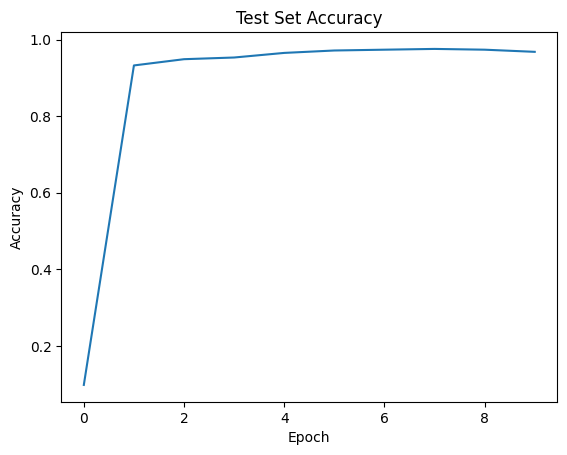

In [19]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## 4.2 尖峰计数器

对一批数据前向运行传递以获得尖峰和膜读数

In [20]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

修改 `idx` 允许索引模拟小批量中的各种样本。 可以使用`splt.spike_count`探索几个不同样本的尖峰行为！

> 注意：如果您在桌面上本地运行笔记本，请取消注释下面的行并修改 ffmpeg.exe 的路径


The target label is: 9


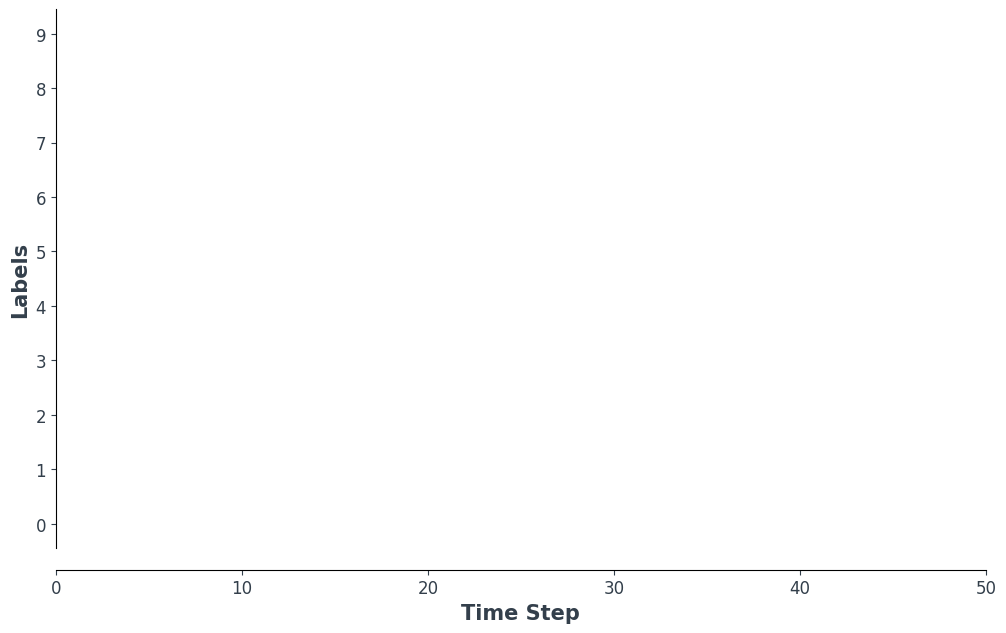

In [21]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

plt.rcParams['animation.ffmpeg_path'] = 'D:\\GoodApp\\ffmpeg\\bin\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

# 结论
你现在应该掌握了 snnTorch 的基本功能，并能够开始运行自己的实验。 [在下一个教程中](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)，我们将使用神经形态数据集训练网络。

特别感谢 [Gianfrancesco Angelini](https://github.com/gianfa) 提供有关本教程的宝贵反馈。

如果您喜欢这个项目，请考虑为 GitHub 上的存储库加⭐，因为这是支持它的最简单、最好的方式。

# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)